## Hyperparameters

In [1]:
WORD2VEC_DIMENSION = 100
DROPOUT_RATE = 0.3
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
MAX_EPOCH = 100 
WEIGHT_DECAY = 1e-5
THRESHOLD = 0.4

LOGISTICLOSS = True

output = False
OVER_SAMPLING = False
WEIGHTED_RANDOM_SAMPLER = False

## import 

In [2]:
import torch
import re
import sys
import json
import math
import os
import pickle
import pandas as pd
import scipy.sparse as sp
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.autograd import Variable
from tqdm import trange
from multiprocessing import Pool
from nltk.tokenize import word_tokenize
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [3]:
import torch
torch.manual_seed(42)

## Data Overview

In [4]:
import pandas as pd

In [5]:
train_xy = pd.read_csv('irtm_final_training_data/train.csv')
train_xy.head()

,comment,label
0,"This is a wonderful album, that evokes memorie...",1
1,"On one hand, this CD is a straight ahead instr...",1
2,this band reminds me of the thrill i first got...,1
3,"Like I said I would, I finally got around to p...",1
4,Ok good CD. im not suprised. Ok jaheim may not...,1


In [6]:
label_1 = train_xy[train_xy.label==1]
label_0 = train_xy[train_xy.label==0]

print('# of label 1:',len(label_1))
print('# of label 2:',len(label_0))

# of label 1: 16223
# of label 2: 12208


In [7]:
import matplotlib.pyplot as plt

labels=['label 1', 'label 0']
separeted = (0.1, 0) 
p=plt.pie([len(label_1), len(label_0)],
        labels = labels,                # 標籤
        autopct = "%1.1f%%",            # 將數值百分比並留到小數點一位
        explode = separeted,            # 設定分隔的區塊位置
        pctdistance = 0.5,              # 數字距圓心的距離
        textprops = {"fontsize" : 12},  # 文字大小
        shadow=True)                    # 設定陰影['label 1', 'label 0'])

### test data

In [8]:
import json

with open('data.json', 'rb') as f:
    js = json.load(f)

texts = []
for commodity in js: 
    replies = commodity['replies']
    text = [reply['text'] for reply in replies]
    texts += text
    
df = pd.DataFrame(texts,columns=['comment'])
df.to_csv('test_x.csv',index=False)

In [9]:
test_x = pd.read_csv('test_x.csv')
test_x.head()

,comment
0,Two scents not two cents. I was thinking the t...
1,Same lol
2,Exactly!
3,Looks like 15$ in gift cards not 20 am I wrong?
4,only seeing $15 GC


In [10]:
train_xy.head()

,comment,label
0,"This is a wonderful album, that evokes memorie...",1
1,"On one hand, this CD is a straight ahead instr...",1
2,this band reminds me of the thrill i first got...,1
3,"Like I said I would, I finally got around to p...",1
4,Ok good CD. im not suprised. Ok jaheim may not...,1


In [11]:
import re
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

## Preprocess

In [12]:
with open('apostrophe.json','rb') as f:
    apostrophe_dict = json.load(f)

In [13]:
with open('short_word.json', 'rb') as f:
    short_word_dict = json.load(f)

In [14]:
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [15]:
import re
import string 
import spacy
import emoji

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm",disable=['parser', 'tagger', 'ner'])

class PreProcessComments:
    def __init__(self):
        self._stopwords = set(list(string.punctuation)) -set(["'","’"])
        
    def processComments(self, df):
        processedComments=[]
        for i, comment in df.iterrows():
            if 'label' in comment:
                processedComments.append((self._processComment(comment["comment"]), comment["label"]))
            else:
                processedComments.append(self._processComment(comment["comment"]))
        return processedComments
    
    def tokenize(self, text):
        
        comment = [token.text.strip() for token in nlp(text)]
        comment = [token for token in comment if token not in emoji.UNICODE_EMOJI]  # remove emoji
        comment = ' '.join(comment)
        return comment
    
    
    def _processComment(self, comment):
        
        sents = split_into_sentences(comment)
        if sents:
            sents = [sent for sent in sents if sent not in string.punctuation]
        
        else:
            sents = [comment]
        
        processed_sents = []
        for comment in sents:
            comment = re.sub('(URL|@user)', '', comment) 
            comment = comment.lower() # convert text to lower-case
            comment = re.sub(r'#([^\s]+)', r'\1', comment) # remove the # in #hashtag

            # make it more clear
            comment = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', comment) # remove potential URLs
            comment = re.sub('@[^\s]+', '', comment) # remove potential usernames

            # transform 
            comment = lookup_dict(comment,apostrophe_dict)
            comment = lookup_dict(comment,short_word_dict)

            # remove punctuation
            comment = comment.translate(str.maketrans('', '', string.punctuation))

            comment = re.sub('(“|”)', '', comment) 

            comment = self.tokenize(comment) 

            comment = re.sub(r'[^A-Za-z’]+', ' ', comment) # remove non alphanumeric character
            
            processed_sents.append(comment.strip())
        
        return processed_sents


In [16]:
%%time
commentProcessor = PreProcessComments()
trainset_list = commentProcessor.processComments(train_xy)
testset_list = commentProcessor.processComments(test_x)

CPU times: user 37.8 s, sys: 17.2 ms, total: 37.8 s
Wall time: 37.8 s


In [17]:
df_trainset = pd.DataFrame(trainset_list, columns=['comment','label'])

data_list = [{'comment':sents} for sents in testset_list]
testset = pd.DataFrame(data_list)
df_trainset.head()

,comment,label
0,[this is a wonderful album that evokes memorie...,1
1,[on one hand this cd is a straight ahead instr...,1
2,[this band reminds me of the thrill i first go...,1
3,[like i said i would i finally got around to p...,1
4,"[ok good cd, i m not suprised, ok jaheim may n...",1


In [18]:
testset.head()

,comment
0,"[two scents not two cents, i was thinking the ..."
1,[same laugh out loud]
2,[exactly]
3,[looks like in gift cards not am i wrong]
4,[only seeing gc]


## split valid

In [19]:
from sklearn.model_selection import train_test_split

trainset, validset = train_test_split(df_trainset, test_size=0.2, shuffle=True, random_state=42)


trainset.to_csv('trainset.csv', index=False)
validset.to_csv('validset.csv', index=False)
testset.to_csv('testset.csv', index=False)

In [20]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22744 entries, 23326 to 23654
Data columns (total 2 columns):
comment    22744 non-null object
label      22744 non-null int64
dtypes: int64(1), object(1)
memory usage: 533.1+ KB


In [21]:
validset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5687 entries, 7486 to 5070
Data columns (total 2 columns):
comment    5687 non-null object
label      5687 non-null int64
dtypes: int64(1), object(1)
memory usage: 133.3+ KB


## train word2vec

In [22]:
%%time
from gensim.models import Word2Vec

if not os.path.exists('saved_files'):
    os.mkdir('saved_files')


if os.path.isfile('saved_files/w2v.model'):
    print('Load existing w2v model')
    with open('saved_files/w2v.model','rb') as f:
        w2v_model = pickle.load(f)
else:
    tokenized_text = []
    for sents in trainset.comment.tolist():
        for sent in sents:
            tokenized_text.append(sent.split())

    print(tokenized_text[:5])
    w2v_model = Word2Vec(tokenized_text, size=WORD2VEC_DIMENSION, workers=4, iter=5, min_count=1, seed=44)
    w2v_model.save('saved_files/w2v.model')

[['i', 'loved', 'having', 'this', 'easyswaddleme', 'wrap'], ['it', 'was', 'so', 'much', 'easier', 'than', 'getting', 'a', 'blanket', 'and', 'swaddling', 'where', 'it', 'might', 'come', 'apart'], ['the', 'velcro', 'worked', 'really', 'well', 'as', 'it', 'gave', 'room', 'to', 'grow'], ['swaddling', 'our', 'daughter', 'only', 'lasted', 'for', 'about', 'a', 'month', 'or', 'two', 'she', 'just', 'totally', 'outgrew', 'this'], ['i', 'was', 'very', 'unhappy', 'with', 'this', 'product']]
CPU times: user 26.9 s, sys: 308 ms, total: 27.2 s
Wall time: 15.4 s


In [23]:
w2v_model.wv['trump'].shape

(100,)

In [24]:
w2v_model.wv.most_similar(positive=['trump'], topn=10)

[('simplified', 0.9565351009368896),
 ('gentry', 0.956162691116333),
 ('muy', 0.955984354019165),
 ('ser', 0.955478310585022),
 ('vacaciones', 0.9552344083786011),
 ('xe', 0.9548598527908325),
 ('lone', 0.954126238822937),
 ('palmer', 0.9538081884384155),
 ('kiefer', 0.9536734819412231),
 ('jimmy', 0.9535713791847229)]

In [25]:
len(w2v_model.wv.vocab.keys())

62058

## Embedding class to save pretrained embedding

In [26]:
import re
import torch
# from sklearn.preprocessing import LabelEncoder, OneHotEncoder

class Embedding:
    """
    Args:
        embedding_path (str): Path where embedding are loaded from (text file).
        words (None or list): If not None, only load embedding of the words in
            the list.
        oov_as_unk (bool): If argument `words` are provided, whether or not
            treat words in `words` but not in embedding file as `<unk>`. If
            true, OOV will be mapped to the index of `<unk>`. Otherwise,
            embedding of those OOV will be randomly initialize and their
            indices will be after non-OOV.
        lower (bool): Whether or not lower the words.
        rand_seed (int): Random seed for embedding initialization.
    """

    def __init__(self, embedding_path=None,
                 words=None, oov_as_unk=True, lower=True, rand_seed=524):
        self.word_dict = {}
        self.index_dict = {}
        self.vectors = None
        self.lower = lower
        
        self.extend(embedding_path, words, oov_as_unk)
        torch.manual_seed(rand_seed)

        if '<pad>' not in self.word_dict:
            self.add(
                '<pad>', torch.zeros(self.get_dim())
            )
        
        if '<sos>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<sos>', t_tensor
            )
            
        if '<eos>' not in self.word_dict:
            t_tensor = torch.rand((1, self.get_dim()), dtype=torch.float)
            torch.nn.init.orthogonal_(t_tensor)
            self.add(
                '<eos>', t_tensor
            )
        
        if '<unk>' not in self.word_dict:
            self.add('<unk>')

    def to_word(self, index):
        return self.index_dict[index]
    
    def to_index(self, word):
        """
        Args:
            word (str)

        Return:
             index of the word. If the word is not in `words` and not in the
             embedding file, then index of `<unk>` will be returned.
        """
        if self.lower:
            word = word.lower()

        if word not in self.word_dict:
            return self.word_dict['<unk>']
        else:
            return self.word_dict[word]

    def get_dim(self):
        return self.vectors.shape[1]

    def get_vocabulary_size(self):
        return self.vectors.shape[0]

    def add(self, word, vector=None):
        if self.lower:
            word = word.lower()

        if vector is not None:
            vector = vector.view(1, -1)
        else:
            vector = torch.empty(1, self.get_dim())
            torch.nn.init.uniform_(vector)
            
        self.vectors = torch.cat([self.vectors, vector], 0)
        self.index_dict[len(self.word_dict)] = word
        self.word_dict[word] = len(self.word_dict)

    def extend(self, embedding_path, words, oov_as_unk=True):
        
        if embedding_path is None:
            self._load_w2v_embedding(words)
        else:
            self._load_embedding(embedding_path, words)

        if words is not None and not oov_as_unk:
            # initialize word vector for OOV
            for word in words:
                if self.lower:
                    word = word.lower()

                if word not in self.word_dict:
                    self.index_dict[len(self.word_dict)] = word
                    self.word_dict[word] = len(self.word_dict)

            oov_vectors = torch.nn.init.uniform_(
                torch.empty(len(self.word_dict) - self.vectors.shape[0],
                            self.vectors.shape[1]))

            self.vectors = torch.cat([self.vectors, oov_vectors], 0)
            
    def _load_w2v_embedding(self, words):
        
        vectors = []
        
        for word in words:
            
            vector = w2v_model.wv[word]
            
            # skip word not in words if words are provided
            if words is not None and word not in words:
                continue
            elif word not in self.word_dict:
                self.index_dict[len(self.word_dict)] = word
                self.word_dict[word] = len(self.word_dict)
                vectors.append([float(v) for v in vector])

        vectors = torch.tensor(vectors)
        if self.vectors is not None:
            self.vectors = torch.cat([self.vectors, vectors], dim=0)
        else:
            self.vectors = vectors
        
    def _one_hot_encoding(self, words):

        vectors = []

        data_le = pd.DataFrame(words, columns=['Word'])
        data_dum = pd.get_dummies(data_le)
        
        for col in data_dum.columns:
            word = col[5:]
            self.index_dict[len(self.word_dict)] = word
            self.word_dict[word] = len(self.word_dict)
            vectors.append([float(row) for row in data_dum[col]])
        
        vectors = torch.tensor(vectors)
        if self.vectors is not None:
            self.vectors = torch.cat([self.vectors, vectors], dim=0)
        else:
            self.vectors = vectors

    def _load_embedding(self, embedding_path, words):
        if words is not None:
            words = set(words)

        vectors = []

        with open(embedding_path) as fp:

            row1 = fp.readline()
            # if the first row is not header
            if not re.match('^[0-9]+ [0-9]+$', row1):
                # seek to 0
                fp.seek(0)
            # otherwise ignore the header

            for i, line in enumerate(fp):
                cols = line.rstrip().split(' ')
                word = cols[0]

                # skip word not in words if words are provided
                if words is not None and word not in words:
                    continue
                elif word not in self.word_dict:
                    self.index_dict[len(self.word_dict)] = word
                    self.word_dict[word] = len(self.word_dict)
                    vectors.append([float(v) for v in cols[1:]])

        vectors = torch.tensor(vectors)
        if self.vectors is not None:
            self.vectors = torch.cat([self.vectors, vectors], dim=0)
        else:
            self.vectors = vectors


In [27]:


if os.path.isfile('saved_files/embedding.pkl'):
    print('Load existing embedding')
    with open('saved_files/embedding.pkl','rb') as f:
        embedder = pickle.load(f)
else:

    words = set(w2v_model.wv.vocab.keys())

    embedder = Embedding(words=words) 
    with open('saved_files/embedding.pkl','wb') as f:
        pickle.dump(embedder, f)

In [28]:
list(embedder.word_dict.items())[-5:]

[('bingy', 62057),
 ('<pad>', 62058),
 ('<sos>', 62059),
 ('<eos>', 62060),
 ('<unk>', 62061)]

In [29]:
len(embedder.word_dict)

62062

## Data formatting

In [30]:
from tqdm import tqdm_notebook as tqdm
        
def label_to_onehot(label):
    onehot = [0,0] 
    onehot[int(label)] = 1
    return onehot
    
def sentence_to_indices(sents, word_dict):
    """ Convert sentence to its word indices.
        We first tokenize the sentence and convert each word into indices.
    Args:
        sentence (str): One string.
    Return:
        indices (list of int): List of word indices.
    """
    indices = []
    for sent in sents:
        indices += [word_dict.to_index(word) for word in sent.split(' ')]
    return indices
    
def get_dataset(dataset, word_dict, n_workers=4):
    """ Load data and return dataset for training and validating.

    Args:
        data_path (str): Path to the data.
    """

    results = [None] * n_workers
    with Pool(processes=n_workers) as pool:
        for i in range(n_workers):
            batch_start = (len(dataset) // n_workers) * i
            if i == n_workers - 1:
                batch_end = len(dataset)
            else:
                batch_end = (len(dataset) // n_workers) * (i + 1)
            
            batch = dataset[batch_start: batch_end]
            results[i] = pool.apply_async(preprocess_samples, args=(batch,word_dict))

        pool.close()
        pool.join()

    processed = []
    for result in results:
        processed += result.get()
    return processed

def preprocess_samples(dataset, word_dict):
    """ Worker function.

    Args:
        dataset (list of dict)
    Returns:
        list of processed dict.
    """
    processed = []
    for sample in tqdm(dataset.iterrows(), total=len(dataset)):
        processed.append(preprocess_sample(sample[1], word_dict))

    return processed

def preprocess_sample(data, word_dict):
    """
    Args:
        data (dict)
    Returns:
        dict
    """
    processed = {}
    processed['comment'] = sentence_to_indices(data['comment'], word_dict)
    if 'label' in data:
        processed['label'] = int(data['label'])
    
    return processed

In [31]:
print('[INFO] Start processing trainset...')
train = get_dataset(trainset, embedder, n_workers=4)
print('[INFO] Start processing validset...')
valid = get_dataset(validset, embedder, n_workers=4)
print('[INFO] Start processing testset...')
test = get_dataset(testset, embedder, n_workers=4)

[INFO] Start processing trainset...




[INFO] Start processing validset...




[INFO] Start processing testset...






## Dataset

In [32]:
list(embedder.word_dict.items())[-5:]

[('bingy', 62057),
 ('<pad>', 62058),
 ('<sos>', 62059),
 ('<eos>', 62060),
 ('<unk>', 62061)]

In [33]:
vector_len = len(embedder.word_dict)
print(vector_len)

62062


In [34]:
from torch.utils.data import Dataset
import torch

class sentimentDataset(Dataset):
    def __init__(self, data, pad_idx, unk_idx, vector_len):
        self.data = data
        self.pad_idx = pad_idx
        self.unk_idx = unk_idx
        self.vector_len = vector_len
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]
    
    def pad_seq(self, seq, max_length):
        '''
        Pad a with the PAD symbol
        '''
        seq += [self.pad_idx]*(max_length - len(seq))
        return seq
        
    def collate_fn(self, datas):
        batch_comments = []
        batch_labels = []
        bow_vector = torch.zeros((len(datas), vector_len))
        
        for i,data in enumerate(datas):
            for idx in data['comment']:
                if idx==self.pad_idx or idx==self.unk_idx:
                    continue
                bow_vector[i][idx] += 1
            
            # gather labels
            if 'label' in data:
                batch_labels.append(int(data['label']))
            
        return bow_vector, torch.FloatTensor(batch_labels)

In [35]:
pad_idx = embedder.word_dict['<pad>']
print ('index of <pad> in word_dict:', pad_idx)
unk_idx = embedder.word_dict['<unk>']
print ('index of <unk> in word_dict:', unk_idx)
vector_len = len(embedder.word_dict)
print('length of BOW vector:',vector_len)

trainData = sentimentDataset(train, pad_idx, unk_idx, vector_len)
validData = sentimentDataset(valid, pad_idx, unk_idx, vector_len)
testData = sentimentDataset(test, pad_idx, unk_idx, vector_len)

index of <pad> in word_dict: 62058
index of <unk> in word_dict: 62061
length of BOW vector: 62062


## Model

## BOW Model

In [36]:
class BOWmodel(nn.Module):
    def __init__(self, input_size):
        super(BOWmodel, self).__init__()
        
        self.input_size = input_size
        self.fc1 = nn.Sequential(
            nn.Dropout(DROPOUT_RATE),  
            nn.ReLU(),
            nn.Linear(self.input_size, 1024),
        )
        
        self.fc2 = nn.Sequential(
            nn.Dropout(DROPOUT_RATE),  
            nn.ReLU(),
            nn.Linear(1024, 256),
        )

        self.fc3 = nn.Sequential(
            nn.Dropout(DROPOUT_RATE),  
            nn.ReLU(),
            nn.Linear(256, 64),
        )
        
        self.fc4 = nn.Sequential(
            nn.Dropout(DROPOUT_RATE),  
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def forward(self, x):

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        
        if not LOGISTICLOSS:
            x = torch.sigmoid(x)
    
        return x

# Training

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [38]:
class F1():
    def __init__(self):
        self.threshold = THRESHOLD
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        self.name = 'F1'
        
        self.N = 0
        self.correct = 0

    def reset(self):
        self.n_precision = 0
        self.n_recall = 0
        self.n_corrects = 0
        
        self.N = 0
        self.correct = 0
        
    def update(self, predicts, groundTruth):

        if LOGISTICLOSS:
            predicts = torch.sigmoid(predicts)
        predicts = predicts > self.threshold
        self.n_precision += torch.sum(predicts).data.item()
        self.n_recall += torch.sum(groundTruth).data.item()
        self.n_corrects += torch.sum(groundTruth.type(torch.uint8) * predicts.type(torch.uint8)).data.item()


    def get_score(self, score='F1'):
        
        recall = self.n_corrects / self.n_recall
        precision = self.n_corrects / (self.n_precision + 1e-20)
        f1 = 2 * (recall * precision) / (recall + precision + 1e-20)
        if score=='recall':
            return recall
        elif score=='precision':
            return precision
        else:
            return f1

    def print_score(self):
        score = self.get_score(score='F1')
        return '{:.5f}'.format(score)


In [40]:
import os
def _run_epoch(epoch, training):
    model.train(training)
    if training:
        description = 'Train'
        dataset = trainData
        shuffle = True
    else:
        description = 'Valid'
        dataset = validData
        shuffle = False
    
    if WEIGHTED_RANDOM_SAMPLER:
        weights = torch.FloatTensor([0.5])
        train_sampler = WeightedRandomSampler(weights,len(dataset),replacement=True)
        dataloader = DataLoader(dataset, sampler=train_sampler,
                                batch_size=BATCH_SIZE,
                                collate_fn=dataset.collate_fn,
                                num_workers=4)
    
    else:
        dataloader = DataLoader(dataset=dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=shuffle,
                                collate_fn=dataset.collate_fn,
                                num_workers=4)

    trange = tqdm(enumerate(dataloader), total=len(dataloader), desc=description)
    loss = 0
    f1_score = F1()
    for i, (x, y) in trange:

        o_labels, batch_loss = _run_iter(x,y)
        if training:
            opt.zero_grad()
            batch_loss.backward()
            opt.step()

        loss += batch_loss.item()
        f1_score.update(o_labels.cpu(), y)

        trange.set_postfix(
            loss=loss / (i + 1), f1=f1_score.print_score())
    if training:
        history['train'].append({'f1':f1_score.get_score(score='F1'), 'loss':loss/ len(trange), 
                                 'precision':f1_score.get_score(score='precision'), 'recall':f1_score.get_score(score='recall')})
    else:
        history['valid'].append({'f1':f1_score.get_score(score='F1'), 'loss':loss/ len(trange), 
                                 'precision':f1_score.get_score(score='precision'), 'recall':f1_score.get_score(score='recall')})
def _run_iter(x,y):
    comments = x.to(device)
    labels = y.to(device)
    o_labels = model(comments)
    o_labels = o_labels.flatten()
    l_loss = criteria(o_labels, labels)
    return o_labels, l_loss

def save(epoch):
    if not os.path.exists('model'):
        os.makedirs('model')
    torch.save(model.state_dict(), 'model/model.pkl.'+str(epoch))
    with open('model/history.json', 'w') as f:
        json.dump(history, f, indent=4)

## Hyperparameters

In [56]:
WORD2VEC_DIMENSION = 100
DROPOUT_RATE = 0.3
BATCH_SIZE = 1024
LEARNING_RATE = 1e-4
MAX_EPOCH = 20
WEIGHT_DECAY = 1e-5
THRESHOLD = 0.55

GRU_DOUBLE_LAYERS = True
INIT_GRU = True
LOGISTICLOSS = True

BOW = True
output = False
OVER_SAMPLING = False

In [57]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm import trange
import json

if BOW:
    model = BOWmodel(embedder.get_vocabulary_size())
else:
    model = simpleNet(embedder.get_dim())
    embedding = nn.Embedding(embedder.get_vocabulary_size(),embedder.get_dim(),padding_idx = pad_idx)
    embedding.weight = torch.nn.Parameter(embedder.vectors)
    
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

if not LOGISTICLOSS:
    criteria = torch.nn.BCELoss()
else:
    criteria = torch.nn.BCEWithLogitsLoss()

model.to(device)
max_epoch = MAX_EPOCH
history = {'train':[],'valid':[]}


## traaaaaaaaaaaaaain

In [58]:
%%time
for epoch in range(max_epoch):
    print('Epoch: {}'.format(epoch))
    _run_epoch(epoch, True)
    _run_epoch(epoch, False)
    save(epoch)

Epoch: 0



Epoch: 1



Epoch: 2



Epoch: 3



Epoch: 4



Epoch: 5



Epoch: 6



Epoch: 7



Epoch: 8



Epoch: 9



Epoch: 10



Epoch: 11



Epoch: 12



Epoch: 13



Epoch: 14



Epoch: 15



Epoch: 16



Epoch: 17



Epoch: 18



Epoch: 19



CPU times: user 32 s, sys: 29.1 s, total: 1min 1s
Wall time: 4min 14s


# Plot

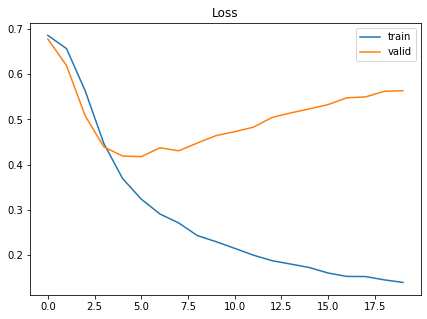

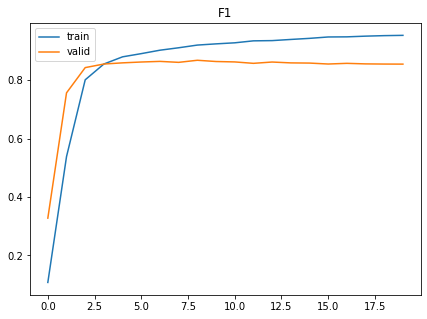

Best f1  0.8685354519562286
Best precision  0.8463336254747298
Best recall  0.8919334975369458


In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

with open('model/history.json', 'r') as f:
    history = json.loads(f.read())
    
train_loss = [l['loss'] for l in history['train']]
valid_loss = [l['loss'] for l in history['valid']]
train_f1 = [l['f1'] for l in history['train']]
valid_f1 = [l['f1'] for l in history['valid']]

plt.figure(figsize=(7,5))
plt.title('Loss')
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='valid')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('F1')
plt.plot(train_f1, label='train')
plt.plot(valid_f1, label='valid')
plt.legend()
plt.show()

idx = valid_f1.index(max(valid_f1))

print('Best f1 ', history['valid'][idx]['f1'])
print('Best precision ', history['valid'][idx]['precision'])
print('Best recall ', history['valid'][idx]['recall'])